# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their log-probability calculations, gradient calculation (via autodiff) and their large library of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant.

In this notebook, we use the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) and show how the model can be defined in Stan but called from in Pints.

In [3]:
import pystan

Define Stan model using their syntax.

In [4]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

Then compile Stan model (we also show code below to save the compiled model to avoid having to redo compilation).

In [6]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e11919b5314121a277ebece94b64d05 NOW.


Import the Eight Schools ("centered" parameterisation) model from Pints.

In [12]:
import os
os.chdir("../..")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

model = pints.toy.EightSchoolsLogPDF()

Use the data provided with Pints' toy model to run Stan's NUTS for a few iterations (only needed so that we can access the functions bound to a stanfit object, so ignore warnings).

In [13]:
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)
names = fit.unconstrained_param_names()

In [33]:
boundaries = pints.RectangularBoundaries([0, 400], [0.03, 600])
lower = boundaries.lower()
lower[0]

0.0

In [28]:
log_prior = pints.UniformLogPrior([2, -7], [4, -5])
log_prior([])

2

In [24]:
class StanLogPDF(pints.LogPDF):
    def __init__(self, stanfit, rectangular_boundaries=None):
        if not fit.__class__.__name__=='StanFit4Model':
            raise ValueError('Stan fit object must be of class StanFit4Model.')
        self._fit = stanfit
        self._log_prob = stanfit.log_prob
        self._grad_log_prob = stanfit.grad_log_prob
        self._u_to_c = stanfit.unconstrain_pars
        self._names = stanfit.unconstrained_param_names()
        dict = {names[i]: [] for i in range(len(keys))}
        self._boundaries = None
        self._lower = None
        self._upper = None
        if rectangular_boundaries is not None:
            if not isinstance(rectangular_boundaries, pints.RectangularBoundaries):
                raise ValueError('Any boundaries must be of class `pints.RectangularBoundaries`.')
            if uniform_log_prior.n_parameters() != len(self._names):
                raise ValueErrors('Dimensionality of boundaries must equal that of Stan fit.')
            self._boundaries = rectangular_boundaries
            self._lower = rectangular_boundaries.lower()
            self._upper = rectangular_boundaries.upper()
    
    def __call__(self, x):
        # handle case when tau < 0 is proposed (otherwise Stan throws error)
        lower = self._lower
        upper = self._upper
        for xs in x:
            if xs < lower[] or xs > upper
        self._dict_update(x)
        return self._log_prob(self._u_to_c(self._dict_dynamic), adjust_transform=True)

Define a `pints.LogPDF` that wraps stanfit object. In doing this, it is important to note that we will be using the `log_prob` and `grad_log_prob` functions bound to the stanfit object to calculate the log probability and gradient (both of which remove any constants from the log probability). These functions operate in an unconstrained space, so we also need to use the `unconstrain_pars` argument to convert constrained parameters to be unconstrained.

In [6]:
class EightSchoolsStanLogPDF(pints.LogPDF):
    def __init__(self, stanfit):
        self._fit = stanfit
        self._log_prob = stanfit.log_prob
        self._grad_log_prob = stanfit.grad_log_prob
        # Stan takes dictionary of parameter values
        self._dict_dynamic = {'mu':1, 'tau':1, 'theta': [2] * 8}
        # convert variables from unconstrained to constrained space
        self._u_to_c = stanfit.unconstrain_pars

    def __call__(self, x):
        # handle case when tau < 0 is proposed (otherwise Stan throws error)
        if x[1] < 0:
            print("hello")
            return -np.inf
        self._dict_update(x)
        return self._log_prob(self._u_to_c(self._dict_dynamic), adjust_transform=True)
    
    def _dict_update(self, x):
        self._dict_dynamic["mu"] = x[0]
        self._dict_dynamic["tau"] = x[1]
        self._dict_dynamic["theta"] = x[2:]
    
    def evaluateS1(self, x):
        # handle case when tau < 0 is proposed (otherwise Stan throws error)
        if x[1] < 0:
            return -np.inf, np.repeat(1e6,10)
        self._dict_update(x)
        uncons = self._u_to_c(self._dict_dynamic)
        return self._log_prob(uncons, adjust_transform=True), self._grad_log_prob(uncons, adjust_transform=True)

    def n_parameters(self):
        return 10

Run [relativistic HMC](../sampling/relativistic-mcmc.ipynb) sampler using this model.

In [7]:
# instantiate Pints version of Stan model
stanmodel = EightSchoolsStanLogPDF(fit)

# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.25      0.5       0.5        0:00.0
3     244    0.6       0.4       0.6       0.4        0:00.0
400   32004  0.627     0.657     0.888     0.821      0:05.8
800   64004  0.706     0.742     0.803     0.765586   0:11.6
1200  96004  0.72      0.733777  0.79      0.762      0:17.4
1600  128004  0.742     0.738     0.806     0.772784   0:23.2
2000  159924  0.741     0.762     0.771     0.763      0:29.0
Halting: Maximum number of iterations (2000) reached.
Done!


In [8]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start), parameter_names=fit.unconstrained_param_names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
mu       3.09    3.59    -1.79   0.63   2.17   4.41   12.16    1.27    33.06  1.14
tau      3.58    1.86    0.65    2.10   3.40   4.88   7.55     1.12    28.09  0.97
theta.1  4.43    6.59    -2.77   0.23   2.31   6.31   23.16    1.35    40.48  1.40
theta.2  4.59    4.67    -2.41   1.02   3.64   7.63   15.57    1.21    33.91  1.17
theta.3  2.68    5.41    -5.10   -0.32  1.47   4.52   19.35    1.25    23.46  0.81
theta.4  2.07    4.96    -8.16   -0.92  1.99   5.20   11.72    1.18    19.18  0.66
theta.5  3.37    3.82    -3.68   0.38   2.95   6.66   10.09    1.23    21.91  0.76
theta.6  2.18    3.74    -4.53   -0.50  1.81   4.72   9.56     1.22    27.72  0.96
theta.7  5.09    4.58    -1.64   1.49   4.64   7.95   17.42    1.13    20.44  0.71
theta.8  2.84    4.09    -5.49   0.08   2.59   6.23   9.60     1.14  

The wandering chains here illustrate how difficult inference is for this model.

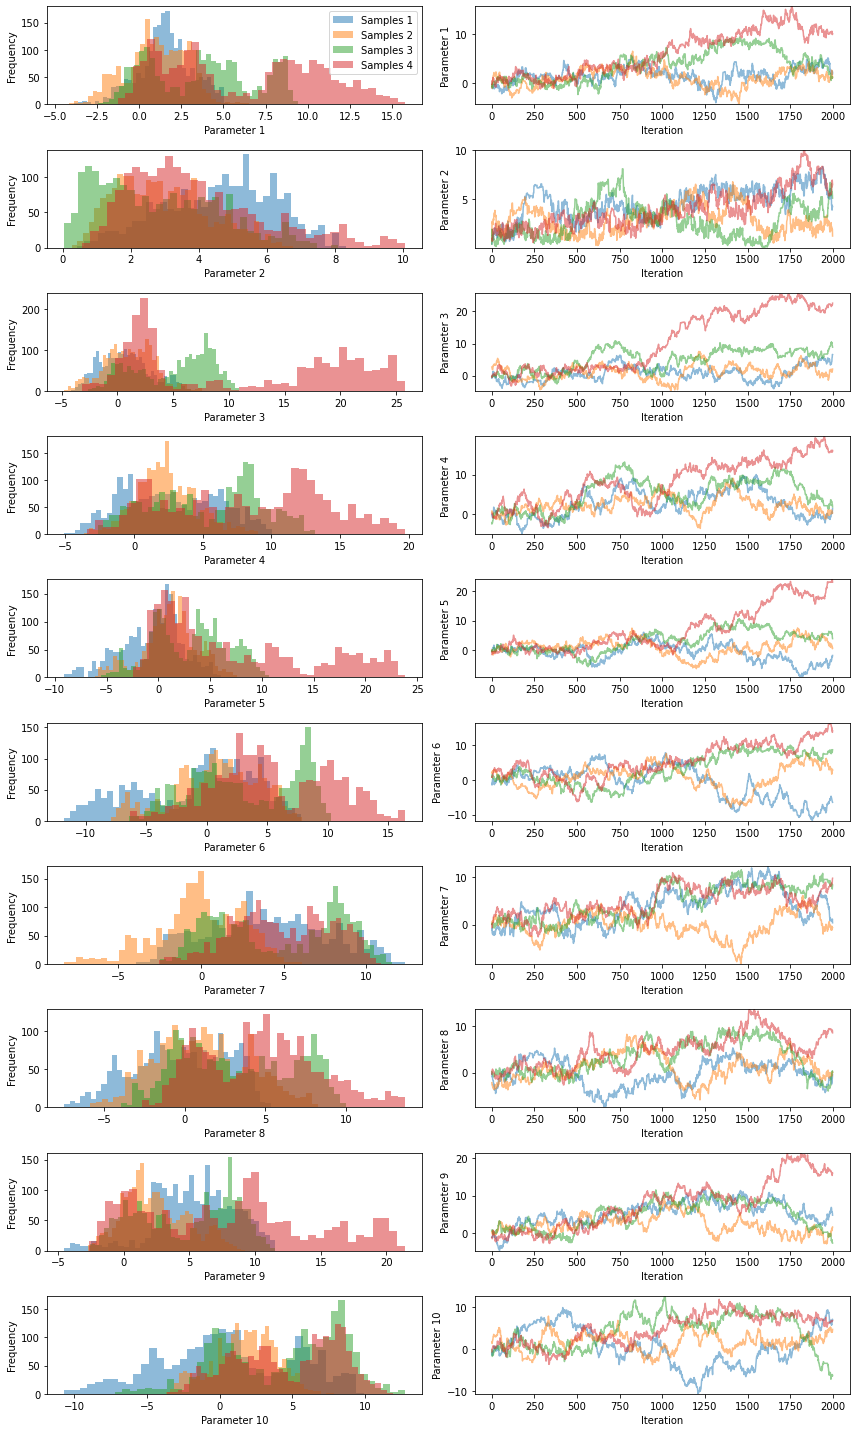

In [9]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [10]:
params = np.random.uniform(size=10)

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(params))))
print(str("Pints log prob: " + str(pintsmodel(params))))

Stan log prob: -4.17821804388143
Pints log prob: -43.36123990388288


The same goes for sensitivities!

In [11]:
p1, dp1 = stanmodel.evaluateS1(params)
p2, dp2 = pintsmodel.evaluateS1(params)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: -2.2537807910706467
Pints d log(prob)/dmu: -0.026998618144186217


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [12]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Compile Stan model and run it for a few iterations to get a stanfit object.

In [13]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model_ncp.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model_ncp.pkl', 'rb'))

# Run Stan model for a few iterations
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Wrap the Stan model in Pints. Note that the parameter names have changed from 'theta' to 'theta.tilde'.

In [14]:
class EightSchoolsNonCenteredStanLogPDF(pints.LogPDF):
    def __init__(self, stanfit):
        self._fit = stanfit
        self._log_prob = stanfit.log_prob
        self._grad_log_prob = stanfit.grad_log_prob
        # Stan takes dictionary of parameter values
        self._dict_dynamic = {'mu':1, 'tau':1, 'theta_tilde': [2] * 8}
        # convert variables from unconstrained to constrained space
        self._u_to_c = stanfit.unconstrain_pars

    def __call__(self, x):
        # handle case when tau < 0 is proposed (otherwise Stan throws error)
        if x[1] < 0:
            print("hello")
            return -np.inf
        self._dict_update(x)
        return self._log_prob(self._u_to_c(self._dict_dynamic), adjust_transform=True)
    
    def _dict_update(self, x):
        self._dict_dynamic["mu"] = x[0]
        self._dict_dynamic["tau"] = x[1]
        self._dict_dynamic["theta_tilde"] = x[2:]
    
    def evaluateS1(self, x):
        # handle case when tau < 0 is proposed (otherwise Stan throws error)
        if x[1] < 0:
            return -np.inf, np.repeat(1e6,10)
        self._dict_update(x)
        uncons = self._u_to_c(self._dict_dynamic)
        return self._log_prob(uncons, adjust_transform=True), self._grad_log_prob(uncons, adjust_transform=True)

    def n_parameters(self):
        return 10

Retry sampling, this time with the non-centered parameterisation.

In [15]:
# instantiate Pints version of Stan model
stanmodel = EightSchoolsNonCenteredStanLogPDF(fit)

# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = 5+np.random.uniform()

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(200)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.4       0.6       0.6       0.4        0:00.0
200   16004  0.960396  0.752     0.871     0.866      0:02.4
400   32004  0.943     0.729     0.913     0.880597   0:04.7
600   48004  0.925     0.789     0.909     0.882      0:07.1
800   64004  0.924     0.82      0.91      0.901      0:09.5
1000  80004  0.897     0.841     0.907     0.913      0:11.8
1200  96004  0.897     0.838     0.91      0.917      0:14.2
1400  112004  0.904     0.824     0.909     0.916      0:16.6
1600  128004  0.902     0.823     0.916     0.903      0:18.9
1800  144004  0.902     0.838     0.917     0.906      0:21.3
2000  160004  0.904     0.843     0.91      0.901    

Obtain $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [16]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1))

Aaaaahh, that's better...

In [17]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=names)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu       4.60    3.48    -3.06   2.46   4.93   6.74   11.70    1.06    56.71   1.19
tau      5.88    3.95    0.85    3.18   5.04   7.33   17.42    1.08    53.24   1.12
theta.1  8.05    7.18    -3.28   3.46   6.94   11.31  25.65    1.01    133.63  2.81
theta.2  5.73    5.42    -4.73   2.36   5.53   8.83   17.42    1.01    375.36  7.90
theta.3  3.50    6.85    -11.94  -0.06  4.15   7.58   15.85    1.02    224.23  4.72
theta.4  5.16    5.69    -6.54   1.70   5.20   8.64   16.63    1.02    287.57  6.06
theta.5  2.99    5.68    -9.99   -0.19  3.44   6.61   13.34    1.01    233.64  4.92
theta.6  3.91    5.59    -7.64   0.59   3.93   7.25   15.05    1.00    331.07  6.97
theta.7  8.26    6.29    -2.20   4.05   7.44   11.64  23.09    1.03    170.44  3.59
theta.8  5.79    6.86    -7.98   1.87   5.67   9.37   20.7

...much more efficient sampling!

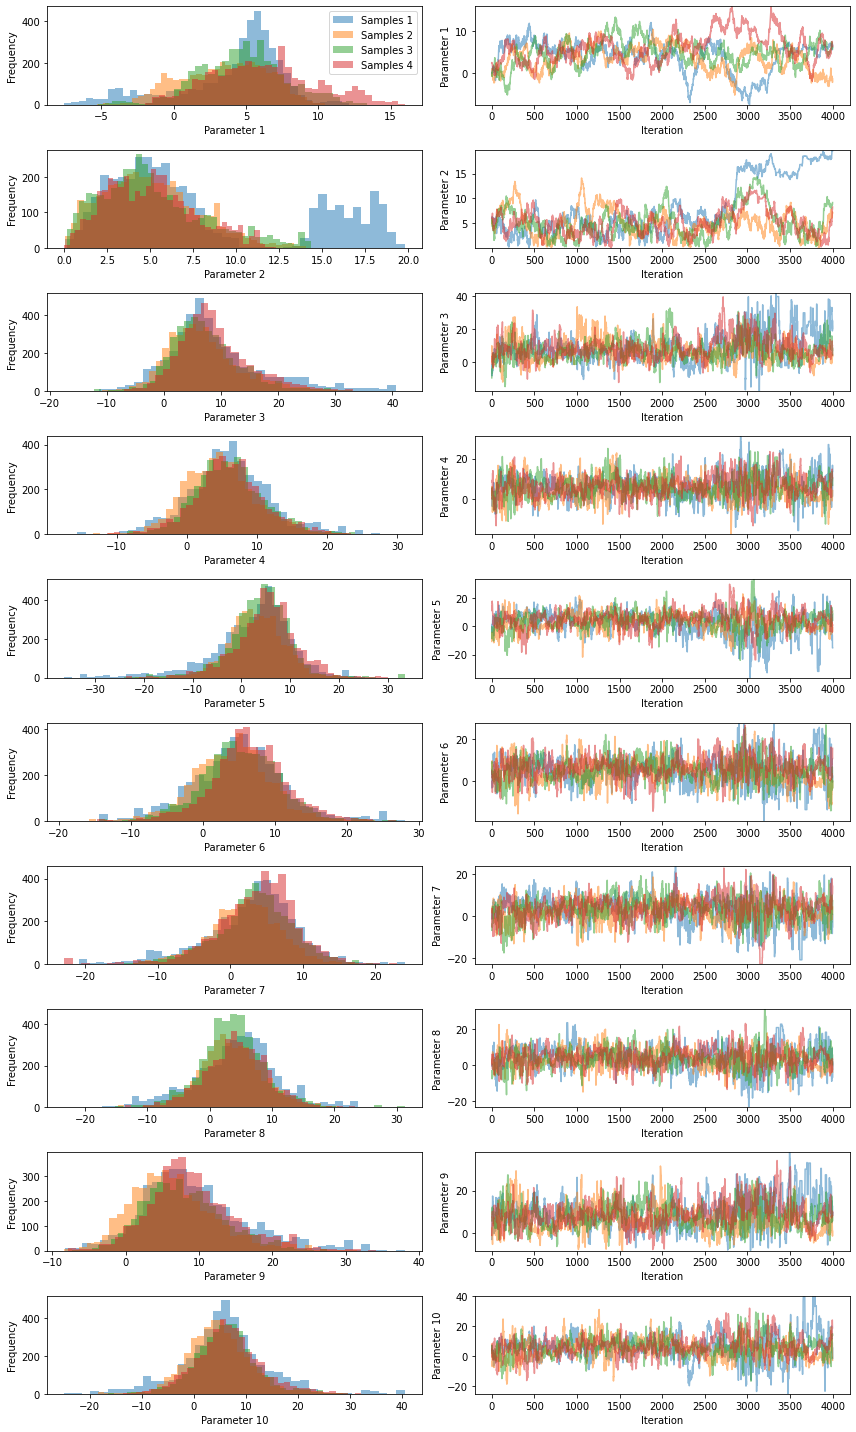

In [18]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()